# Practical for Seasonal Forecasts
In this practical, we will use some forecast models to generate some seaonal precipitation forecasts, and then assess how their raw forecasts compared with some techniques to bias correct (i.e. postprocess) their outputs

Postprocessing techniques assessed will include: CCA, EPO-ELM, and ELR

This notebook should be run in the intdesk_train environment - check your kernel (upper righthand corner) is set to 'intdesk_train', so you have all necessary libraries


## Libraries

In [26]:
import xcast as xc
import datetime as dt
import numpy as np
from pathlib import Path
import xarray as xr
import os
import time
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import glob

## Project Directory Setup

In [27]:
# setup the folder where you want to work for this project
# either type in the location, or place this notebook in the folder where you want your project to live and set project_dir = os.getcwd()
project_dir = os.getcwd()#"/Users/katie/Desktop/trial_pacisl" 

#make subdirectores to organize your work within the project if they don't already exist
os.makedirs(os.path.join(project_dir, 'practical_data'), exist_ok = True)
data_dir = os.path.join(project_dir, 'practical_data')
os.makedirs(os.path.join(data_dir, 'nc_files'), exist_ok = True)
nc_dir = os.path.join(data_dir, 'nc_files')
os.makedirs(os.path.join(project_dir, 'practical_figures'), exist_ok = True)
figure_dir = os.path.join(project_dir, 'practical_figures')

## Pick your Models, Observational Data, and Initialization Date

In [28]:
#Pick Some Forecast Models to Test
gcms = ['NMME']#'GEOSS2S','SPEAR', 'CCSM4', 'CanSIPSIC3', 'CFSv2', 
#Pick Some Observed Rainfall Data to Evaluate Predictions
# options include 'UCSB0p05', 'UCSB', or CMORPH
obs_name = 'CMORPH'

#Pick the date you want to initialize the model, e.g. your current date
initial_date = (2024, 1, 1)

#where you want to target your final analysis
predictand_extent = {
        'west':  153,
        'east': 183,  
        'north': 3,  
        'south': -20
      }

fiji_coordinates = {
        'west':  177,
        'east': 182,  
        'north': -15,  
        'south': -20}

kiribati_coordinates = {
        'west':  155,
        'east': 178,  
        'north': 2,  
        'south': 0}

solomon_coordinates = {
        'west':  155,
        'east': 167,  
        'north': -13,  
        'south': -6}

region_of_interest = 'kiribati'

## Prepare Data for Analysis

### Calculate Seasons to Forecast Based on Initialization Date

In [30]:
#this cell is setup to calculate your target forecast months based on your initialization date
#the forecast months are currently seto to be 1-3, 2-4 and 3-5 months ahead
number_to_month_name_dictionary = {
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec',
    0: 'Dec'
}

leads = [['1', '3'],['2', '4'], ['3','5']]
initial_month = dt.datetime(*initial_date).month
initial_month_name = number_to_month_name_dictionary[initial_month]
target_months = []
for l in leads:
    target_low = number_to_month_name_dictionary[(initial_month + float(l[0]))%12]
    target_high = number_to_month_name_dictionary[(initial_month + float(l[1]))%12]
    target_months.append('-'.join([target_low, target_high]))
print('Target seasons to forecast')
print(target_months)

Target seasons to forecast
['Feb-Apr', 'Mar-May', 'Apr-Jun']


### Load observations from file for target seasons

In [31]:
obs_leads = []
for t, target in enumerate(target_months):
    #obs_download_file = '{}*.nc'.format('_'.join([target_months[t], obs_name]))
    obs_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + str(t + 1), obs_name]))
    Y = xr.open_dataset(glob.glob(os.path.join(nc_dir, obs_download_file))[0])
    print(Y)
    Y.isel(time=0).precip.plot()
    Y = getattr(Y, [i for i in Y.data_vars][0])
    if obs_name == 'CMORPH':
        Y = Y.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[0]})
    Y = Y.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    
    #slice to predictand zone of interest
    Y = Y.sel(X=slice(predictand_extent['west'], predictand_extent['east']),
              Y=slice(predictand_extent['south'], predictand_extent['north']))
    obs_leads.append(Y)

#check all years are available for all lead times in hindcast period, only keep intersecting years
nyears = []
for obs in obs_leads:
    nyears.append(len(np.unique(obs.S.values)))
if all(i==nyears[0] for i in nyears) == True:
    obs_leads = xr.concat(obs_leads, dim = 'L')
else:
    seas_years = []
    for obs in obs_leads:
        base_obs = obs.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        seas_years.append(np.unique(base_obs.T.dt.year.values))
    intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

    updated_obs = []
    for obs in obs_leads:
        obs_check = obs.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        updated_obs.append(obs_check.sel(T=obs_check.T.dt.year.isin(intersecting_years)).swap_dims({'T':'S'}).prec)
    obs_leads = xr.concat(updated_obs, dim = 'L')

<xarray.Dataset>
Dimensions:  (lat: 401, lon: 1441, time: 75)
Coordinates:
  * lat      (lat) float32 -50.0 -49.75 -49.5 -49.25 ... 49.25 49.5 49.75 50.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * time     (time) datetime64[ns] 2024-01-12 2025-01-12 ... 2098-01-12
Data variables:
    precip   (time, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:  (lat: 401, lon: 1441, time: 75)
Coordinates:
  * lat      (lat) float32 -50.0 -49.75 -49.5 -49.25 ... 49.25 49.5 49.75 50.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * time     (time) datetime64[ns] 2024-01-12 2025-01-12 ... 2098-01-12
Data variables:
    precip   (time, lat, lon) float64 ...
<xarray.Dataset>
Dimensions:  (lat: 401, lon: 1441, time: 75)
Coordinates:
  * lat      (lat) float32 -50.0 -49.75 -49.5 -49.25 ... 49.25 49.5 49.75 50.0
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * time     (time) datetime64[ns] 2024-01-12 2

### Load model data (forecasts and hindcasts) from file for target seasons

In [6]:
# read in hindcast and forecast data
hindcast_data, forecast_data = [], []
for t, target in enumerate(target_months):
    hindcast_data_l, forecast_data_l = [], []
    for gcm in gcms:
        
        # gcm_hindcast_download_file = '{}*.nc'.format('_'.join([target, '_'.join(leads[t]), 'raw_hind', gcm]))
        # gcm_forecast_download_file = '{}*.nc'.format('_'.join([target, '_'.join(leads[t]), 'raw_fcst', gcm]))
        gcm_hindcast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], gcm, 'hind']))
        gcm_forecast_download_file = '{}*.nc'.format('_'.join([initial_month_name, 'ld' + leads[t][0], gcm, 'fcst']))
        g = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_hindcast_download_file))[0]).precip
        f = xr.open_dataset(glob.glob(os.path.join(nc_dir, gcm_forecast_download_file))[0]).precip
        g = g.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[gcm]})
        f = f.rename({'lat':'Y', 'lon':'X', 'time':'T'}).expand_dims({'M':[gcm]})
        hindcast_data_l.append(g)
        forecast_data_l.append(f)
    hindcast_data_l = xr.concat(hindcast_data_l, dim = 'M')
    forecast_data_l = xr.concat(forecast_data_l, dim = 'M')
    hindcast_data_l = hindcast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    forecast_data_l = forecast_data_l.expand_dims({'L':[t+1]}).swap_dims({'T':'S'})
    hindcast_data.append(hindcast_data_l)
    forecast_data.append(forecast_data_l)

#create one dataset across all lead times of interest
forecast_data = xr.concat(forecast_data, dim = 'L')
#check all hindcast years are available for all lead times and only keep dataset with intersecting years
nyears = []
for hcsts in hindcast_data:
    nyears.append(len(np.unique(hcsts.S.values)))
if all(i==nyears[0] for i in nyears) == True:
    hindcast_data = xr.concat(hindcast_data, dim = 'L')
else:
    seas_years = []
    for hcst in hindcast_data:
        base_hcsts = hcst.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        seas_years.append(np.unique(base_hcsts.T.dt.year.values))
    intersecting_years = [x for x in seas_years[0] if x in seas_years[1] and x in seas_years[2]]

    updated_hcsts = []
    for hcst in hindcast_data:
        hcst_check = hcst.swap_dims({'S':'T'}).to_dataset(name = 'prec')
        updated_hcsts.append(hcst_check.sel(Ti=hcst_check.Ti.dt.year.isin(intersecting_years)).swap_dims({'T':'S'}).prec)
    hindcast_data = xr.concat(updated_hcsts, dim = 'L')

In [7]:
forecast_data

<xarray.DataArray 'precip' (L: 3, M: 1, S: 1, Y: 181, X: 361)>
array([[[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [0.22311737, 0.22386454, 0.22470592, ..., 0.22156772,
           0.22234727, 0.22311737],
          [0.21646763, 0.21942697, 0.22290719, ..., 0.21001427,
           0.21342047, 0.21646763],
          ...,
          [1.34652758, 1.34761333, 1.34842122, ..., 1.35265267,
           1.34954572, 1.34652758],
          [1.27283251, 1.27263153, 1.27243865, ..., 1.27591014,
           1.27430689, 1.27283251],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]],



       [[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [0.22754194, 0.22835183, 0.22920936, ..., 0.2259402 ,
           0.2267444 , 0.22754194],
...
          [1.21343577, 1.21284103, 1.212479  , ..., 1.21661389,
           1.21500111, 1.21343577],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]],



       [[[[       nan,        nan,        nan, ...,        nan,
                  nan,        nan],
          [0.23431511, 0.23511264, 0.23592466, ..., 0.23274945,
           0.23352958, 0.23431511],
          [0.21662694, 0.21950728, 0.22299148, ..., 0.21042477,
           0.21391563, 0.21662694],
          ...,
          [1.04325533, 1.04257441, 1.04191554, ..., 1.0466671 ,
           1.04527068, 1.04325533],
          [1.01449585, 1.01362133, 1.01300764, ..., 1.01711035,
           1.0156765 , 1.01449585],
          [       nan,        nan,        nan, ...,        nan,
                  nan,        nan]]]]])
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) object 'NMME'
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0 180.0
    T        (S) datetime64[ns] 2024-01-01
Dimensions without coordinates: S
Attributes:
    units:          mm
    standard_name:  Precip

In [8]:
hindcast_data

<xarray.DataArray 'precip' (L: 3, M: 1, S: 75, Y: 181, X: 361)>
array([[[[[         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          ...,
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan]],

         [[         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
...
          [271.72540283, 271.72488403, 271.72451782, ...,
           271.72631836, 271.72592163, 271.72540283],
          [271.7227478 , 271.72244263, 271.72216797, ...,
           271.72348022, 271.72311401, 271.7227478 ],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan]],

         [[         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan],
          ...,
          [271.74761963, 271.74691772, 271.74633789, ...,
           271.74871826, 271.74829102, 271.74761963],
          [271.74584961, 271.74545288, 271.74514771, ...,
           271.74664307, 271.74621582, 271.74584961],
          [         nan,          nan,          nan, ...,
                    nan,          nan,          nan]]]]])
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) object 'NMME'
  * Y        (Y) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * X        (X) float32 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0 180.0
    T        (S) datetime64[ns] 2024-01-01 2025-01-01 ... 2097-01-01 2098-01-01
Dimensions without coordinates: S
Attributes:
    units:          mm
    standard_name:  Sea_surface_temperature

In [21]:
obs_leads

<xarray.DataArray 'precip' (L: 3, M: 1, S: 75, Y: 93, X: 109)>
array([[[[[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
...
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]],

         [[nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          ...,
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan],
          [nan, nan, nan, ..., nan, nan, nan]]]]])
Coordinates:
  * L        (L) int64 1 2 3
  * M        (M) int64 0
  * Y        (Y) float32 -20.0 -19.75 -19.5 -19.25 -19.0 ... 2.25 2.5 2.75 3.0
  * X        (X) float32 153.0 153.2 153.5 153.8 ... 179.2 179.5 179.8 180.0
    T        (S) datetime64[ns] 2024-01-12 2025-01-12 ... 2097-01-12 2098-01-12
Dimensions without coordinates: S
Attributes:
    units:          K
    standard_name:  Sea_surface_temperature

### Compare datasets, check all years exist in both hindcast and obs datasets

In [12]:
hindcast_comp = []
obs_comp = []
for l in np.unique(hindcast_data.L):
    model = hindcast_data.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    obs = obs_leads.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')

    model_years = np.unique(model.T.dt.year.values)
    obs_years = np.unique(obs.T.dt.year.values)
    intersecting_years = [x for x in obs_years if x in model_years]
    hindcast_comp.append(model.sel(T=model.T.dt.year.isin(intersecting_years)).prec.swap_dims({'T':'S'}))
    obs_comp.append(obs.sel(T=obs.T.dt.year.isin(intersecting_years)).prec.swap_dims({'T':'S'}))
hindcast_comp = xr.concat(hindcast_comp, dim = 'L')
obs_comp = xr.concat(obs_comp, dim = 'L')

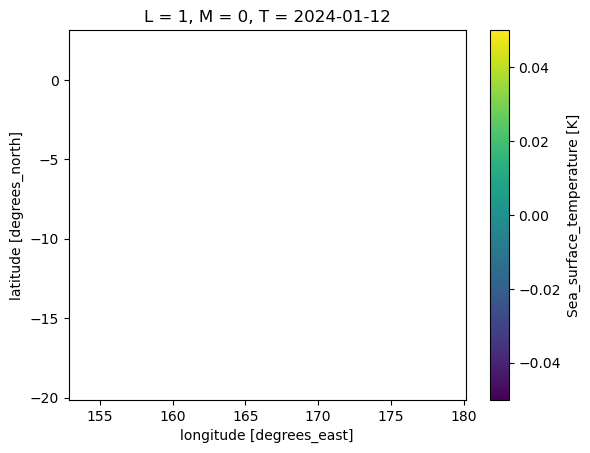

In [22]:
obs_leads.isel(M=0,L=0,S=0).plot()

## Analysis

### Bias correct raw model outputs using Canonical Correlation Analysis (CCA)

In [16]:
start_time = time.time()
cca_fcsts_prob, cca_fcsts_det, cca_hcasts_det, cca_hcasts_prob= [],[],[],[]

for l in np.unique(hindcast_comp.L):
    model = hindcast_comp.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    obs = obs_leads.sel(L=l).swap_dims({'S':'T'}).to_dataset(name = 'prec')
    fmodel = forecast_data.sel(L=l).swap_dims({'S':'T'})

    model_years = np.unique(model.T.dt.year.values)
    obs_years = np.unique(obs.T.dt.year.values)
    intersecting_years = [x for x in obs_years if x in model_years]
    model = model.sel(T=model.T.dt.year.isin(intersecting_years)).prec
    obs = obs.sel(T=obs.T.dt.year.isin(intersecting_years)).prec

    #run CCA
    hindcasts_det, hindcasts_prob = [], []
    i=1
    for xtrain, ytrain, xtest, ytest in xc.CrossValidator(model, obs, window=1):
        print("window {}".format(i))
        i += 1
        reg = xc.CCA(search_override=(10,
                                      10,
                                     3))
        print(xtrain)
        print(ytrain)
        reg.fit(xtrain, ytrain)
        preds = reg.predict(xtest)
        probs =  reg.predict_proba(xtest)
        hindcasts_det.append(preds)
        hindcasts_prob.append(probs)
    hindcasts_det = xr.concat(hindcasts_det, 'T')
    hindcasts_prob = xr.concat(hindcasts_prob, 'T')
    
    fprobs =  reg.predict_proba(fmodel)
    
    cca_fcsts_prob.append(fprobs.swap_dims({'T':'S'}))
    cca_hcasts_det.append(hindcasts_det.swap_dims({'T':'S'}))
    cca_hcasts_prob.append(hindcasts_prob.swap_dims({'T':'S'}))
cca_fcsts_prob = xr.concat(cca_fcsts_prob, dim = 'L')
cca_hcasts_det = xr.concat(cca_hcasts_det, dim = 'L')
cca_hcasts_prob = xr.concat(cca_hcasts_prob, dim = 'L')
print('cca processing time is ' + str(time.time() - start_time))

window 1
<xarray.DataArray 'prec' (M: 1, T: 74, Y: 181, X: 361)>
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
...
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, n

ValueError: zero-size array to reduction operation minimum which has no identity

## Evaluate Performance of Raw vs Bias Corrected Models

In [ ]:
hindcast_slice = hindcast_comp.sel(X=slice(predictand_extent['west'], predictand_extent['east']),
                                       Y=slice(predictand_extent['north'], predictand_extent['south']))
hindcast_slice

In [ ]:
#calculate pearson correlation score for hindcasts
pearson_cca, pearson_raw = [], []
for l, lead in enumerate(np.unique(hindcast_comp.L.values)):
    cca_pearson_calc = xc.Pearson(cca_hcasts_det.isel(L=l).swap_dims({'S':'T'}),
                             obs_comp.isel(L=l).swap_dims({'S':'T'}))
    cca_pearson_calc = cca_pearson_calc.expand_dims({'M':['CCA Across Models']})

    #regrid raw data for pearson calculation on one to one grid
    hindcast_slice = hindcast_comp.sel(X=slice(predictand_extent['west'], predictand_extent['east']),
                                       Y=slice(predictand_extent['north'], predictand_extent['south']))
    obs_slice = obs_comp.sel(X=slice(predictand_extent['west'], predictand_extent['east']),
                                       Y=slice(predictand_extent['north'], predictand_extent['south']))
    raw_regrid = xc.regrid(hidncast_slice.isel(L=l), obs_slice.X, obs_slice.Y)
    pearson_raw_calc = []
    for m, model in enumerate(np.unique(raw_regrid.M.values)):
        pearson_raw_c = xc.Pearson(raw_regrid.sel(M=model).expand_dims({'M':[model]}).swap_dims({'S':'T'}), 
                                           obs_comp.isel(L=l).swap_dims({'S': 'T'}))
        pearson_raw_c = pearson_raw_c.expand_dims({'M':[model]})
        pearson_raw_calc.append(pearson_raw_c)
    pearson_raw_calc = xr.concat(pearson_raw_calc, dim = 'M')
    pearson_cca.append(cca_pearson_calc)
    pearson_raw.append(pearson_raw_calc)
pearson_cca = xr.concat(pearson_cca, dim = 'L')
pearson_raw = xr.concat(pearson_raw, dim = 'L')
pearsons = xr.concat([pearson_cca, pearson_raw], dim = 'M')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_months.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, 14), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([predictand_extent['west'], predictand_extent['east'], predictand_extent['south'], predictand_extent['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label('Pacific Islands Pearson Correlation Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, 'pearson_CCA' + obs_name.split('.')[0]), bbox_inches='tight', dpi=100)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature

# Assuming you have data for models and seasons
models = np.unique(pearsons.M.values)
seasons = target_months.copy()

fig, axes = plt.subplots(nrows=len(models), ncols=len(seasons), figsize=(10, 14), 
                         subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Set the extent to cover the entire world
for ax in axes.flat:
    ax.set_global()

for j, model in enumerate(models):
    for i, season in enumerate(seasons):
        ax = axes[j, i]
        # Your plotting code here using the specific model and season
        xplot = pearsons.isel(L=i, M=j).plot(ax=ax,
                                              transform=ccrs.PlateCarree(),
                                              cmap='coolwarm', levels=21, vmin=-1, vmax=1, add_colorbar=False)
        ax.coastlines()
        c = ax.coastlines()
        c = ax.gridlines(draw_labels=True, linewidth=0.3)
        c.right_labels = False
        c.top_labels = False 
        # Add country borders
        ax.add_feature(NaturalEarthFeature(category='cultural', name='admin_0_countries', 
                                            scale='50m', edgecolor='black', facecolor='none'))
        # Set the extent to cover the specific area
        ax.set_extent([fiji_coordinates['west'], fiji_coordinates['east'], fiji_coordinates['south'], fiji_coordinates['north']], crs=ccrs.PlateCarree())
        ax.set_title(f'{model} - {season}')

# Add a single horizontal colorbar below the panel plot
cbar_ax = fig.add_axes([0.15, 0.002, 0.6, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(xplot, cax=cbar_ax, orientation='horizontal', shrink =1, pad = 0.3)
cbar.set_label('Pacific Islands Pearson Correlation Using Multiple Models', fontsize=13)
cbar.ax.tick_params(labelsize=14)
# Adjust layout
plt.subplots_adjust(left=0.05, right=0.9, top=0.95, bottom=0.05, wspace=0.01, hspace=0.2)

# Show plot
plt.savefig(os.path.join(figure_dir, 'Fiji-pearson_CCA' + obs_name.split('.')[0]), bbox_inches='tight', dpi=100)

## Plot some Probabalistic Plots

### Plot the Bias Corrected Forecasts using CCA

In [ ]:
for l, lead in enumerate(np.unique(cca_fcsts_prob.L)):
    im = xc.view_probabilistic(cca_fcsts_prob.isel(S=0, L=l), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_months[l] + 'CCA_forecast' + obs_name + '.png'))

    im_fiji = xc.view_probabilistic(cca_fcsts_prob.isel(S=0, L=l).sel(X=slice(177, 184),
                                                                   Y=slice(-16, -20)), cross_dateline=True,
                             title='CCA MME Probabalistic Forecast over Fiji for ' + target_months[l],
                             savefig=os.path.join(figure_dir, target_months[l] + 'Fiji_CCA_forecast' + obs_name + '.png'))

#### Next Steps
1. Add environment install command to beginning of notebook
2. Test our environment is stable - install the environment on windows; and run this notebook
3. Test our environment is stable round two - instlal the environment on linux; and run this notebook
4. Give our document to others to test - Grace and Ehsan to run
5. Download data for other seasons (4 season skill) and upload to google drive
6. Run ELM, EOPLM, and CCA on 25km and 5km and time how long it takes
7. Add GROC skill score
8. Add RMSE skill score
9. Plot Raw Correlation score
10. Plot Bias Correlation score
11. Add Endalk's consolidated weighted ensemble mean based on correlation score
12. Develop an assignment for the practical session- divide into 4 teams; dividing by seasons - each calculate the raw score, bias corrected, plot the probabalistic forecast
13. Fix figure saving

Current run time for CCA
- 77 seconds for 25'; 35 seconds for 5km

In [ ]:
ohc = xc.OneHotEncoder() 
ohc.fit(obs.rename({'lat':'Y', 'lon':'X', 'time':'T'}))
#T = ohc.transform(obs)
# clim = xr.ones_like(T) * 0.333
# print(T)
# groc=xc.GROCS(hindcasts_prob1, T)
# pl=xc.view(groc,title='GROCS',cmap=plt.get_cmap('RdBu',8),vmin=0,vmax=1)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =hindcasts_det1.isel(M=0, time=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
# Create a figure
fig = plt.figure(figsize=(30, 20))

# Iterate over each month and plot the data
for i, month in enumerate(range(1, 33)):
    #print(month)
    # Add subplot to the figure
    ax = fig.add_subplot(8, 4, i+1, projection=ccrs.PlateCarree(central_longitude=180))

    # Plot data for the current month
    im =obs.isel(year=i).plot(transform=ccrs.PlateCarree(),
                                              subplot_kws={'projection':ccrs.PlateCarree(central_longitude=180)},
                                             vmin=0,vmax=10)

In [ ]:
hindcasts_det.isel(M=0,time=3).plot()

In [ ]:
splot = chirps_pacisl.precip.plot(col = 'time', col_wrap = 5,subplot_kws={'projection':ccrs.PlateCarree()})
                                  # (transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
#splot = splot.plot(transform.ccrs.PleteCareer(), vmin=0, vmax = 600, levels=21)
for ax in  splot.axs.flat:
    coasts = ax.coastlines()
    ax.set_xlim(pred_w, pred_e)
    ax.set_ylim(pred_s, pred_n)
plt.show()

In [ ]:
hmodelt = nmme_mme_hcst.precip.expand_dims({'M':[0]})
fmodelt = nmme_mme_fcst.precip.expand_dims({'M':[0]})
obs = chirps_hcst.precip.expand_dims({'M':[0]})

drymask = xc.drymask(obs, dry_threshold= cfg.dry_threshold)#, quantile_threshold=cfg.quantile_threshold)
obs = obs*drymask
drymask = xc.drymask(hmodelt, cfg.dry_threshold, cfg.quantile_threshold)
modelt = hmodelt*drymask